In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


def load_and_aggregate_results(surrogate, metric, acquisition, seeds, 
                               batch_size, committee_size=20, base_folder="results_"):
    metrics_keys = ["train_loss", "val_loss", "test_loss", "train_r2", "val_r2", "test_r2"]
    all_metrics = {k: [] for k in metrics_keys}

    for seed in seeds:
        if acquisition == "passive":
            file_path = f"{base_folder}{seed}_{batch_size}/history_{acquisition}_rnd{seed}.npz"
        elif surrogate in ["rf", "mc_dropout"]:
            file_path = f"{base_folder}{seed}_{batch_size}/history_{surrogate}{committee_size}_{metric}_{acquisition}_rnd{seed}.npz"
        else:
            file_path = f"{base_folder}{seed}_{batch_size}/history_{surrogate}_{metric}_{acquisition}_rnd{seed}.npz"
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        data = np.load(file_path, allow_pickle=True)
        for k in metrics_keys:
            all_metrics[k].append(data[k])

    # If no files were successfully loaded, return None
    if all(len(all_metrics[k]) == 0 for k in metrics_keys):
        return None, None

    mean_metrics = {}
    std_metrics = {}

    for k in metrics_keys:
        if len(all_metrics[k]) == 0:
            continue  # Skip metrics with no data
        stacked = np.stack(all_metrics[k], axis=0)
        mean_metrics[k] = np.mean(stacked, axis=0)
        std_metrics[k] = np.std(stacked, axis=0)

    return mean_metrics, std_metrics


In [2]:
# Example usage
mean_metrics_example, std_metrics_example = load_and_aggregate_results(
    surrogate="gp",
    metric="UCS",
    acquisition="greedy",
    seeds=[16],
    batch_size="4096"
)

df_mean_metrics_mean = pd.DataFrame(mean_metrics_example)
df_mean_metrics_mean.head()

,train_loss,val_loss,test_loss,train_r2,val_r2,test_r2
0,16.408852,16.008544,15.919716,-1.267217,-1.241117,-1.258357
1,15.458065,15.925546,15.837104,-1.397285,-1.229495,-1.246636
2,14.930120,15.834179,15.746276,-1.278997,-1.216703,-1.233749
3,14.660263,15.725977,15.638823,-1.168137,-1.201553,-1.218504
4,13.700085,15.588512,15.502286,-1.106036,-1.182306,-1.199132


In [3]:
df_mean_metrics_std = pd.DataFrame(std_metrics_example)
df_mean_metrics_std.head()

,train_loss,val_loss,test_loss,train_r2,val_r2,test_r2
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
safe_colors = ['blue', 'red', 'black', 'cyan', 'orange', 'brown']

# Configuration
surrogates = ['gp', 'rf', 'bayes_linear', 'mc_dropout']
metrics = ['UCS', 'DBS']
acquisitions = ['greedy', 'mcmc', 'metropolis']
passive_acquisition = 'passive'
seeds = [16]
batch_sizes = [4096, 2048]
committee_sizes = [20, 100]
base_folder = "results_"

# Store all metrics here
all_mean_metrics = {}
all_std_metrics = {}

# Load passive separately (no surrogate)
for batch_size in batch_sizes:
    mean_key = f"passive_bs{batch_size}"
    mean_metrics, std_metrics = load_and_aggregate_results(
        surrogate=None,
        metric=None,
        acquisition=passive_acquisition,
        seeds=seeds,
        batch_size=batch_size,
        base_folder=base_folder
    )
    all_mean_metrics[mean_key] = mean_metrics
    all_std_metrics[mean_key] = std_metrics

# Load all surrogate+acquisition combos
for surrogate in surrogates:
    for acquisition in acquisitions:
        for metric in metrics:
            for batch_size in batch_sizes:
                for committee_size in committee_sizes:
                    if surrogate == "rf" or surrogate ==  "mc_dropout":
                        key = f"{surrogate}{committee_size}_{metric}_{acquisition}_bs{batch_size}"
                    else:
                        key = f"{surrogate}_{metric}_{acquisition}_bs{batch_size}"
                    mean_metrics, std_metrics = load_and_aggregate_results(
                        surrogate=surrogate,
                        metric=metric,
                        acquisition=acquisition,
                        seeds=seeds,
                        batch_size=batch_size,
                        committee_size=committee_size,
                        base_folder=base_folder
                    )
                    all_mean_metrics[key] = mean_metrics
                    all_std_metrics[key] = std_metrics

File not found: results_16_2048/history_rf20_UCS_greedy_rnd16.npz
File not found: results_16_2048/history_rf100_UCS_greedy_rnd16.npz
File not found: results_16_2048/history_rf20_DBS_greedy_rnd16.npz
File not found: results_16_2048/history_rf100_DBS_greedy_rnd16.npz
File not found: results_16_2048/history_rf20_UCS_mcmc_rnd16.npz
File not found: results_16_2048/history_rf100_UCS_mcmc_rnd16.npz
File not found: results_16_2048/history_rf20_DBS_mcmc_rnd16.npz
File not found: results_16_2048/history_rf100_DBS_mcmc_rnd16.npz
File not found: results_16_2048/history_rf20_UCS_metropolis_rnd16.npz
File not found: results_16_2048/history_rf100_UCS_metropolis_rnd16.npz
File not found: results_16_2048/history_rf20_DBS_metropolis_rnd16.npz
File not found: results_16_2048/history_rf100_DBS_metropolis_rnd16.npz
File not found: results_16_2048/history_bayes_linear_UCS_greedy_rnd16.npz
File not found: results_16_2048/history_bayes_linear_UCS_greedy_rnd16.npz
File not found: results_16_2048/history_bayes_

In [5]:
def plot_metric_grouped_by_acquisition(metric_key, surrogate, metric, batch_size, committee_size,
                                       all_mean_metrics, all_std_metrics, show_passive=True,
                                       xlim=None, ylim=None):
    acquisitions = ['greedy', 'mcmc', 'metropolis']
    plt.figure(figsize=(12, 6))
    
    for idx, acquisition in enumerate(acquisitions):
        if surrogate in ['rf', 'mc_dropout']:
            key = f"{surrogate}{committee_size}_{metric}_{acquisition}_bs{batch_size}"
        else:
            key = f"{surrogate}_{metric}_{acquisition}_bs{batch_size}"
        
        if key not in all_mean_metrics:
            print(f"[Skipping] {key} not found.")
            continue

        mean = all_mean_metrics[key][metric_key]
        std = all_std_metrics[key][metric_key]
        color = safe_colors[idx % len(safe_colors)]
        plt.plot(range(len(mean)), mean, label=f"{acquisition}", color=color)
        plt.fill_between(range(len(mean)), mean - std, mean + std, color=color, alpha=0.2)

    if show_passive:
        passive_key = f"passive_bs{batch_size}"
        if passive_key in all_mean_metrics:
            mean = all_mean_metrics[passive_key][metric_key]
            std = all_std_metrics[passive_key][metric_key]
            plt.plot(range(len(mean)), mean, '--', color='gray', label="passive")
            plt.fill_between(range(len(mean)), mean - std, mean + std, color='gray', alpha=0.2)
        else:
            print(f"[Skipping] Passive key not found: {passive_key}")

    title = f"{metric_key} for surrogate={surrogate}, metric={metric}, bs={batch_size}"
    if surrogate in ['rf', 'mc_dropout']:
        title += f", committee size={committee_size}"
    plt.title(title)
    plt.xlabel("Epoch or Batch")
    plt.ylabel(metric_key)
    plt.legend()
    plt.grid(True)
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig(title + ".png", dpi=300, bbox_inches="tight")
    plt.show()


In [6]:
def plot_metric_grouped_by_surrogate(metric_key, acquisition, metric, batch_size, committee_size,
                                     all_mean_metrics, all_std_metrics, show_passive=True,
                                     xlim=None, ylim=None):
    surrogates = ['gp', 'rf', 'bayes_linear', 'mc_dropout']
    plt.figure(figsize=(12, 6))
    
    for idx, surrogate in enumerate(surrogates):
        if surrogate in ['rf', 'mc_dropout']:
            key = f"{surrogate}{committee_size}_{metric}_{acquisition}_bs{batch_size}"
        else:
            key = f"{surrogate}_{metric}_{acquisition}_bs{batch_size}"
        
        if key not in all_mean_metrics:
            print(f"[Skipping] {key} not found.")
            continue

        mean = all_mean_metrics[key][metric_key]
        std = all_std_metrics[key][metric_key]
        color = safe_colors[idx % len(safe_colors)]
        plt.plot(range(len(mean)), mean, label=f"{surrogate}", color=color)
        plt.fill_between(range(len(mean)), mean - std, mean + std, color=color, alpha=0.2)

    if show_passive:
        passive_key = f"passive_bs{batch_size}"
        if passive_key in all_mean_metrics:
            mean = all_mean_metrics[passive_key][metric_key]
            std = all_std_metrics[passive_key][metric_key]
            plt.plot(range(len(mean)), mean, '--', color='gray', label="passive")
            plt.fill_between(range(len(mean)), mean - std, mean + std, color='gray', alpha=0.2)
        else:
            print(f"[Skipping] Passive key not found: {passive_key}")

    title = f"{metric_key} for acquisition={acquisition}, metric={metric}, batch size={batch_size}, committee size={committee_size}"  
    plt.title(title)
    plt.xlabel("Epoch or Batch")
    plt.ylabel(metric_key)
    plt.legend()
    plt.grid(True)
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig(title + ".png", dpi=300, bbox_inches="tight")
    plt.show()


In [7]:
line_style = ['-', '--']


def plot_metric_grouped_by_batch_size_rescaled(
    metric_key,
    acquisition,
    surrogate,
    metric,
    committee_size,
    all_mean_metrics,
    all_std_metrics,
    batch_sizes,
    total_train_size,
    show_passive=True,
    xlim=None,
    ylim=None
):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    
    for idx, batch_size in enumerate(batch_sizes):
        if surrogate in ['rf', 'mc_dropout']:
            key = f"{surrogate}{committee_size}_{metric}_{acquisition}_bs{batch_size}"
        else:
            key = f"{surrogate}_{metric}_{acquisition}_bs{batch_size}"
        
        if key not in all_mean_metrics:
            print(f"[Skipping] {key} not found.")
            continue

        mean = all_mean_metrics[key][metric_key]
        std = all_std_metrics[key][metric_key]

        # Rescale x-axis to cumulative samples seen
        x_values = np.arange(1, len(mean) + 1) * batch_size

        color = safe_colors[idx % len(safe_colors)]
        plt.plot(x_values, mean, label=f"bs={batch_size}", color=color)
        plt.fill_between(x_values, mean - std, mean + std, color=color, alpha=0.2)

    if show_passive:
        for idx, batch_size in enumerate(batch_sizes):
            passive_key = f"passive_bs{batch_size}"
            if passive_key not in all_mean_metrics:
                print(f"[Skipping] Passive key not found: {passive_key}")
                continue
            mean = all_mean_metrics[passive_key][metric_key]
            std = all_std_metrics[passive_key][metric_key]
            x_values = np.arange(1, len(mean) + 1) * batch_size
            if batch_size == 2048:
                plt.plot(x_values, mean, '--', color='grey', label=f"passive (bs={batch_size})")
            else:
                plt.plot(x_values, mean, '--', color='black', label=f"passive (bs={batch_size})")
            plt.fill_between(x_values, mean - std, mean + std, color='gray', alpha=0.2)

    title = f"{metric_key} vs. Samples Seen (Surrogate={surrogate}, Acq={acquisition}), committee size={committee_size}"
    plt.title(title)
    plt.xlabel("Cumulative Samples Seen")
    plt.ylabel(metric_key)
    plt.legend()
    plt.grid(True)

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.savefig(title + ".png", dpi=300, bbox_inches="tight")
    plt.show()

In [8]:
def plot_metric_grouped_by_committee_size(
    metric_key,
    surrogate,
    acquisition,
    metric_type,
    batch_size,
    committee_sizes,
    all_mean_metrics,
    all_std_metrics,
    show_passive=True,
    xlim=None,
    ylim=None
):
    """
    Compare metric across different committee sizes for a given surrogate+acquisition+metric+batch.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    for idx, committee_size in enumerate(committee_sizes):
        if surrogate in ['rf', 'mc_dropout']:
            key = f"{surrogate}{committee_size}_{metric_type}_{acquisition}_bs{batch_size}"
        else:
            key = f"{surrogate}_{metric_type}_{acquisition}_bs{batch_size}"
        
        if key not in all_mean_metrics or all_mean_metrics[key] is None:
            print(f"[Skipping] {key} — no data loaded.")
            continue
        if metric_key not in all_mean_metrics[key]:
            print(f"[Skipping] Metric {metric_key} not found in {key}.")
            continue

        mean = all_mean_metrics[key][metric_key]
        std = all_std_metrics[key][metric_key]
        epochs = np.arange(1, len(mean) + 1)
        color = safe_colors[idx % len(safe_colors)]
        plt.plot(epochs, mean, label=f"Committee {committee_size}", color=color)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color=color)

    if show_passive:
        passive_key = f"passive_bs{batch_size}"
        if passive_key in all_mean_metrics and all_mean_metrics[passive_key] is not None:
            if metric_key in all_mean_metrics[passive_key]:
                mean = all_mean_metrics[passive_key][metric_key]
                std = all_std_metrics[passive_key][metric_key]
                epochs = np.arange(1, len(mean) + 1)
                plt.plot(epochs, mean, '--', color='gray', label="passive")
                plt.fill_between(epochs, mean - std, mean + std, color='gray', alpha=0.2)

    title = f"{metric_key} for {surrogate} - {acquisition} - {metric_type} (Grouped by Committee Size, bs={batch_size})"
    plt.title(title)
    plt.xlabel("Epoch or Batch")
    plt.ylabel(metric_key)
    plt.legend()
    plt.grid(True)

    if 'epochs' in locals():
        max_epoch_or_step = max(epochs)
        xticks = np.arange(0, max_epoch_or_step + 1, 52)
        plt.xticks(xticks)

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.savefig(title + ".png", dpi=300, bbox_inches="tight")
    plt.show()


OSError: [Errno 22] Invalid argument: 'D:\\CB 750 Automation of Scientific Research\\project\\test_loss for surrogate: mc_dropout, metric: UCS, bs=4096, committee size=20.png'

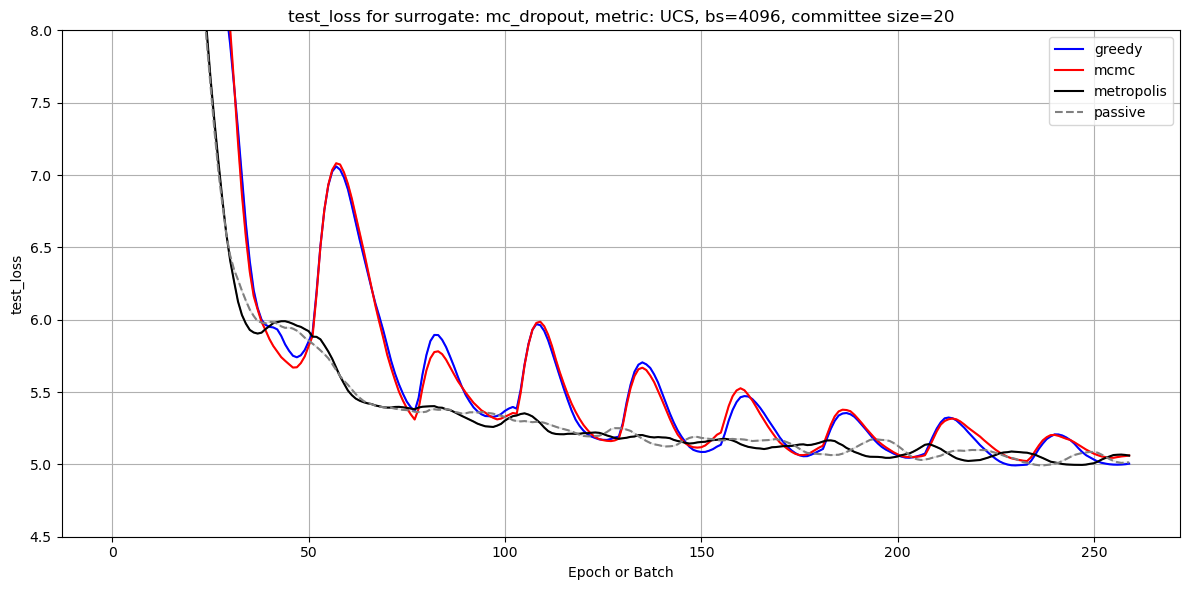

In [9]:
# train_loss val_loss test_loss train_r2 val_r2 test_r2
# 'gp', 'rf', 'bayes_linear', 'mc_dropout'
# 'UCS', 'DBS'
# '4096'
# 'greedy', 'mcmc', 'metropolis'
# 20, 100

window = 0
x_l = 26 * window
x_u = 26 * (window + 2) + 1

plot_metric_grouped_by_acquisition(
    metric_key="test_loss",
    surrogate="mc_dropout",
    metric="UCS",
    batch_size=4096,
    committee_size=20,
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    #xlim=(x_l, x_u)#,
    ylim=(4.5, 8)
)

In [ ]:
# Plot test_loss across surrogate models for a fixed acquisition strategy
plot_metric_grouped_by_surrogate(
    metric_key="test_loss",
    acquisition="greedy",
    metric="UCS",
    batch_size=4096,
    committee_size=20,
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    #xlim=(x_l, x_u)#,
    ylim=(4.5, 8)
)

In [ ]:
window = 0
x_l = 26 * window
x_u = 26 * (window + 2) + 1

plot_metric_grouped_by_batch_size_rescaled(
    metric_key="test_loss",
    acquisition="greedy",
    surrogate="gp",
    metric="UCS",               # Make sure this matches your loaded keys
    committee_size=20,          # e.g., one of the committee sizes you used
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    batch_sizes=batch_sizes,    # [4096, 2048]
    total_train_size=106652,
    show_passive=True,
    #xlim=(0, 110000),
    ylim=(4.5, 8)
)

In [ ]:
plot_metric_grouped_by_committee_size(
    metric_key="test_loss",
    surrogate="rf",
    acquisition="greedy",
    metric_type="UCS",  # not "USC"!
    committee_sizes=committee_sizes,  # [20, 100]
    batch_size=4096,                  # REQUIRED for key construction
    all_mean_metrics=all_mean_metrics,
    all_std_metrics=all_std_metrics,
    show_passive=True,
    #xlim=(0, 260),
    ylim=(4.5, 8)
)